# AutoRegressive Time-series Forecasting with LSTM

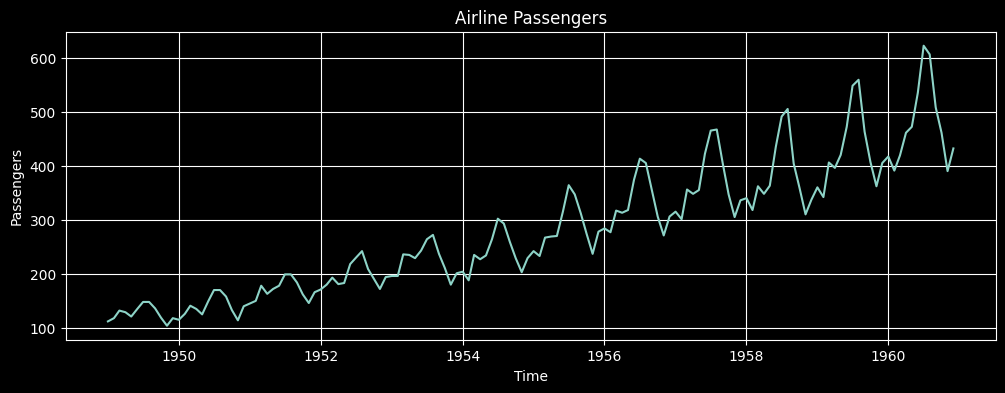

In this notebook, we will explore the use of Long Short-Term Memory (LSTM) networks for time series forecasting. Time series data, such as the monthly number of international airline passengers, often exhibit complex patterns that include trends and seasonality. Traditional statistical methods like ARIMA and SARIMA are useful but may struggle with capturing long-term dependencies and non-linear relationships within the data.

LSTMs, a type of recurrent neural network (RNN), are particularly well-suited for time series forecasting due to their ability to learn from long-term dependencies and manage sequential data effectively. This makes them an excellent choice for forecasting tasks where the underlying patterns are not just linear or short-term.

In this notebook, we will use the Air Passengers dataset, which contains monthly totals of international airline passengers from 1949 to 1960. This dataset is a classic benchmark in time series analysis and will help demonstrate the capabilities of LSTM networks in capturing both trend and seasonality to make accurate forecasts.

We will cover the following steps:

- Data Preprocessing: Preparing the data for input into the LSTM model, including scaling and transforming the time series data into a supervised learning format.
- Building the LSTM Model: Constructing and compiling the LSTM network using Keras.
- Training the Model: Training the LSTM model on the historical data.
- Making Predictions: Using the trained model to forecast future values.
- Evaluating Performance: Assessing the accuracy of the forecasts using appropriate metrics.
By the end of this notebook, you will have a solid understanding of how LSTM networks can be applied to time series forecasting tasks and how to implement such a model using Python and PyTorch.

## Dataset: Airline Passengers
https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

# References:

https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import CosineAnnealingLR

plt.style.use('dark_background')

# Preprocess Data

In [2]:
# Function to encode the month as an angle on the unit circle
def encode_month_as_angle(month):
    angle = (month - 1) * (2*np.pi/12)
    x = np.cos(angle)
    y = np.sin(angle)
    return x, y

In [3]:
# Function to calculate linear trend
def calculate_trend(x):
    x = np.array(x)
    n = x.shape[0]
    A = np.vstack([np.arange(n), np.ones(n)]).T
    m, c = np.linalg.lstsq(A, x, rcond=None)[0]
    trend = m * np.arange(n) + c
    return pd.Series(trend)

In [4]:
data_path = 'datasets/air_passengers/AirPassengers.csv'

window_size = 4
lookahead = 1

In [5]:
# Load the data
df_raw = pd.read_csv(data_path)

In [6]:
# Preprocess the data
df_raw['date'] = pd.to_datetime(df_raw['Month'])
df_raw['passengers'] = df_raw['Passengers'].astype(np.float32)

# Apply the function to encode year and month
df_raw['year'] = df_raw['date'].dt.year.astype(np.float32)
df_raw['month_x'], df_raw['month_y'] = zip(*df_raw['date'].dt.month.apply(encode_month_as_angle))

# Calculate the linear trend
df_raw['trend'] = calculate_trend(df_raw['passengers'])

# Calculate the seasonality
df_raw['detrended'] = df_raw['passengers'] - df_raw['trend']

# Calculate rolling mean and rolling standard deviation
df_raw['rolling_mean'] = df_raw['detrended'].rolling(window=window_size, center=False).mean()
df_raw['rolling_std'] = df_raw['detrended'].rolling(window=window_size, center=False).std()
df_raw['detrended_positive'] = (df_raw['detrended'] > 0).astype(int)

# Drop the original 'Passengers' and 'Month' columns
df_raw.drop(columns=['Passengers', 'Month'], inplace=True)

# Set the 'date' column as the index and sort the DataFrame by the index
df_raw.set_index('date', inplace=True)
df_raw.sort_index(inplace=True)

# Show the DataFrame
df_raw.head()

,passengers,year,month_x,month_y,trend,detrended,rolling_mean,rolling_std,detrended_positive
date,,,,,,,,,
1949-01-01,112.0,1949.0,1.000000e+00,0.000000,90.309962,21.690038,NaN,NaN,1
1949-02-01,118.0,1949.0,8.660254e-01,0.500000,92.967146,25.032854,NaN,NaN,1
1949-03-01,132.0,1949.0,5.000000e-01,0.866025,95.624330,36.375670,NaN,NaN,1
1949-04-01,129.0,1949.0,6.123234e-17,1.000000,98.281513,30.718487,28.454262,6.463646,1
1949-05-01,121.0,1949.0,-5.000000e-01,0.866025,100.938697,20.061303,28.047079,7.055967,1


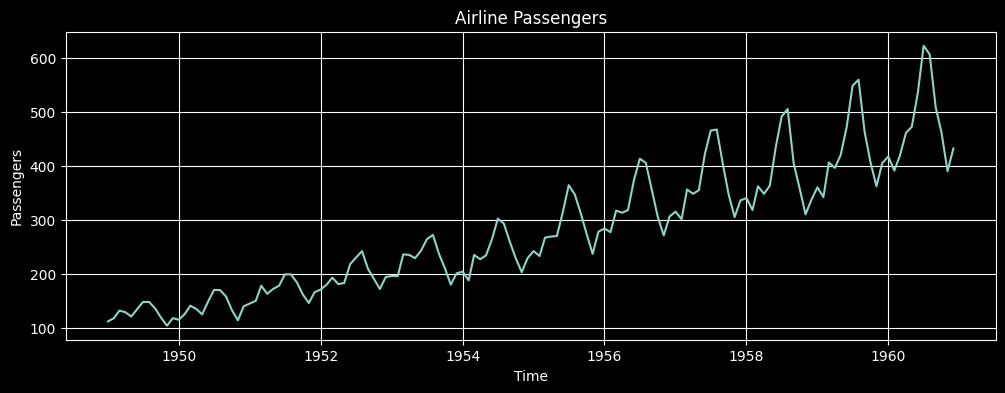

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(df_raw.index, df_raw["passengers"], label="passengers")
plt.title("Airline Passengers")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

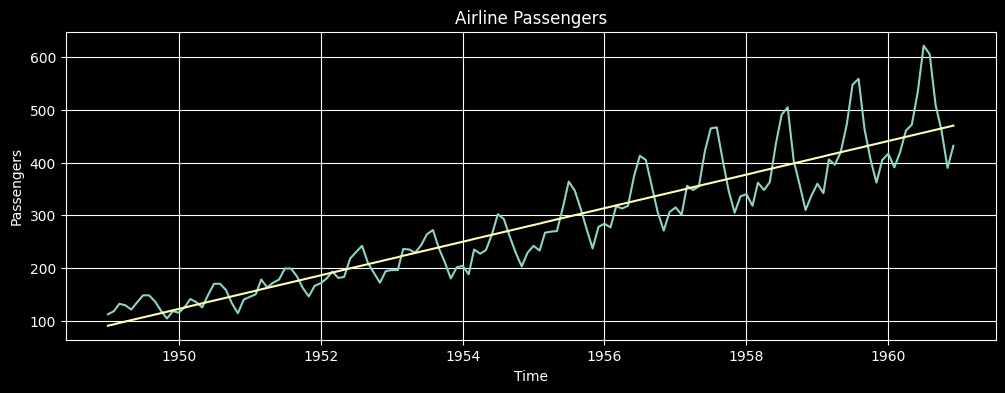

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(df_raw.index, df_raw["passengers"], label="passengers")
plt.plot(df_raw.index, df_raw["trend"], label="trend")
plt.title("Airline Passengers")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

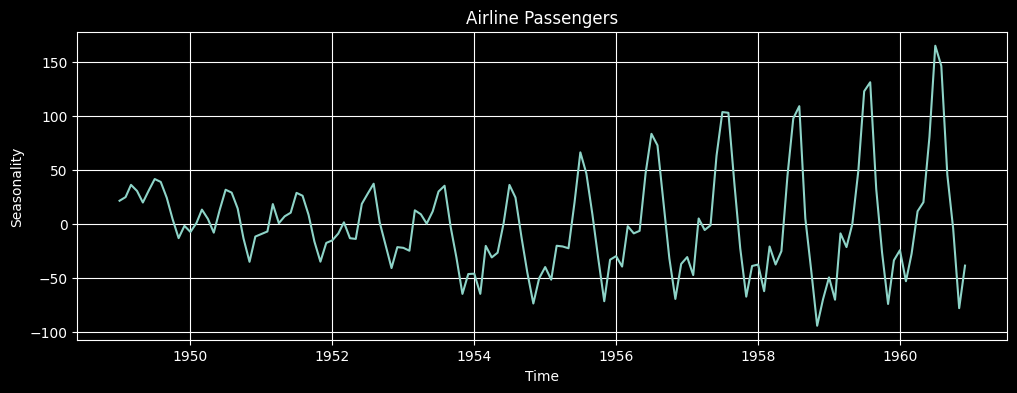

In [9]:
# plot the seasonality
plt.figure(figsize=(12, 4))
plt.plot(df_raw.index, df_raw["detrended"], label="detrended")
plt.title("Airline Passengers")
plt.xlabel("Time")
plt.ylabel("Seasonality")
plt.grid(True)
plt.show()

# Create Training, Validation and Test Sets

In [10]:
# visualize the dataframe
timeseries = df_raw.copy()

In [11]:
# Define the split sizes
train_size = (2/3)
val_size = (1/6)

# Calculate the indices for the splits
n_data = len(timeseries)
train_index_end = int(n_data * train_size)
val_index_end = train_index_end + int(n_data * val_size)

# Split the data
train_df = timeseries.iloc[:train_index_end].dropna()
val_df = timeseries.iloc[train_index_end:val_index_end].dropna()
test_df = timeseries.iloc[val_index_end:].dropna()

In [12]:
train_df

,passengers,year,month_x,month_y,trend,detrended,rolling_mean,rolling_std,detrended_positive
date,,,,,,,,,
1949-04-01,129.0,1949.0,6.123234e-17,1.000000e+00,98.281513,30.718487,28.454262,6.463646,1
1949-05-01,121.0,1949.0,-5.000000e-01,8.660254e-01,100.938697,20.061303,28.047079,7.055967,1
1949-06-01,135.0,1949.0,-8.660254e-01,5.000000e-01,103.595881,31.404119,29.639895,6.865274,1
1949-07-01,148.0,1949.0,-1.000000e+00,1.224647e-16,106.253065,41.746935,30.982711,8.858011,1
1949-08-01,148.0,1949.0,-8.660254e-01,-5.000000e-01,108.910249,39.089751,33.075527,9.721588,1
...,...,...,...,...,...,...,...,...,...
1956-08-01,405.0,1956.0,-8.660254e-01,-5.000000e-01,332.113697,72.886303,49.372079,40.029772,1
1956-09-01,355.0,1956.0,-5.000000e-01,-8.660254e-01,334.770881,20.229119,55.964895,28.288809,1
1956-10-01,306.0,1956.0,-1.836970e-16,-1.000000e+00,337.428065,-31.428065,36.307711,52.964983,0


In [13]:
def create_timeseries_dataset(df:pd.DataFrame, target:str, lookback:int=5, lookahead:int=1):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    x, y = [], []
    n_samples = df.shape[0]
    for i in range(n_samples-lookback):
        # it says lookback, but we're shifting index
        x_sample = df.iloc[i:i+lookback]
        y_sample = df[target].iloc[i+lookback:i+lookback+lookahead]
        x.append(x_sample)
        y.append(y_sample)
    x, y = np.array(x), np.array(y)
    return x, y

In [14]:
lookback = window_size

x_train, y_train = create_timeseries_dataset(df=train_df, target='passengers', lookback=lookback, lookahead=lookahead)
x_val, y_val = create_timeseries_dataset(val_df, target='passengers', lookback=lookback, lookahead=lookahead)
x_test, y_test = create_timeseries_dataset(test_df, target='passengers', lookback=lookback, lookahead=lookahead)

In [15]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)

x_val_scaled = x_scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

x_test_scaled = x_scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

# Transform to PyTorch tensors
x_train_scaled = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_val_scaled = torch.tensor(x_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

x_test_scaled = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [16]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(89, 4, 9) torch.Size([89, 1])
(20, 4, 9) torch.Size([20, 1])
(20, 4, 9) torch.Size([20, 1])


In [17]:
print(x_train[0], y_train[0])

[[ 1.29000000e+02  1.94900000e+03  6.12323400e-17  1.00000000e+00
   9.82815134e+01  3.07184866e+01  2.84542625e+01  6.46364648e+00
   1.00000000e+00]
 [ 1.21000000e+02  1.94900000e+03 -5.00000000e-01  8.66025404e-01
   1.00938697e+02  2.00613027e+01  2.80470785e+01  7.05596741e+00
   1.00000000e+00]
 [ 1.35000000e+02  1.94900000e+03 -8.66025404e-01  5.00000000e-01
   1.03595881e+02  3.14041188e+01  2.96398946e+01  6.86527367e+00
   1.00000000e+00]
 [ 1.48000000e+02  1.94900000e+03 -1.00000000e+00  1.22464680e-16
   1.06253065e+02  4.17469349e+01  3.09827107e+01  8.85801095e+00
   1.00000000e+00]] tensor([148.])


In [18]:
train_dataset = TensorDataset(x_train_scaled, y_train)
val_dataset = TensorDataset(x_val_scaled, y_val)
test_dataset = TensorDataset(x_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [19]:
batch_x, batch_y = next(iter(train_loader))
print(f"Number of batches in train_loader: {len(train_loader)}")
print("Dimensions: (batch, sequence length, features)")
print(f"Shape of x_train: {batch_x.shape}")
print(f"Shape of y_train: {batch_y.shape}")

Number of batches in train_loader: 1
Dimensions: (batch, sequence length, features)
Shape of x_train: torch.Size([89, 4, 9])
Shape of y_train: torch.Size([89, 1])


# Create LSTM Model

In [20]:
def train_regression(model, data_loader, optimizer, criterion, device):
    model.to(device).train()
    batch_loss = []

    for x_train, y_train in data_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total

def validate_regression(model, data_loader, criterion, device):
    model.to(device).eval()
    batch_loss = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            batch_loss.append(loss.item())
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total

def evaluate_regression(model, data_loader, device):
    model.to(device).eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            predictions.append(y_hat)
            actuals.append(y)

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    actuals = torch.cat(actuals, dim=0).cpu().numpy()

    return predictions, actuals

def inference_regression(model:nn.Module, x:torch.tensor, device:torch.device):
    model.eval().to(device)
    with torch.no_grad():
        x = x.to(device)
        y_hat = model(x)
    return y_hat.cpu()

In [21]:
class TimeseriesModel(nn.Module):
    def __init__(self, n_features:int, hidden_size:int, output_size:int, num_layers:int=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Shape: (batch, seq_len, n_features) -> (batch, seq_len, hidden_size), (h_n, c_n)
        x, _ = self.lstm(x)
        # Shape: (batch, seq_len, hidden_size) -> (batch, hidden_size) -> (batch, hidden_size)
        x = self.fc1(self.dropout1(x[:, -1, :]))
        # Shape: (batch, hidden_size) -> (batch, hidden_size)
        x = self.fc2(self.dropout2(F.relu(x)))
        return x

In [22]:
validate = False

if validate:
    batch_size = 16
    seq_len = 4
    n_features = 1
    hidden_size = 128
    output_size = 1
    num_layers = 1

    lstm = nn.LSTM(n_features, hidden_size, num_layers, batch_first=True)
    fc1 = nn.Linear(hidden_size, output_size)
    dropout1 = nn.Dropout(0.2)

    # Shape: (batch_size, seq_length, input_size)
    x_example = torch.randn(batch_size, seq_len, n_features)
    print(f"Input shape: {x_example.shape}")
    #print(f"Input sample values: {x_example}")

    y_example = torch.randn(batch_size, output_size)
    print(f"Label shape: {y_example.shape}")
    #print(f"Label sample values: {y_example}")

    out1, _ = lstm(x_example)
    print(f"LSTM output shape: {out1.shape}")

    out2 = out1[:, -1, :]
    print(f"Reshape Dimensions: {out2.shape}")
    out3 = fc1(dropout1(out2))
    print(f"Linear output shape: {out3.shape}")

# Training Loop

In [23]:
# hyperparameters
n_features = x_train.shape[-1]
hidden_size = 64
output_size = 1
num_layers = 2

# training parameters
n_epochs = 13000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate model, loss function and optimizer
model = TimeseriesModel(n_features=n_features, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

In [24]:
# lists to store loss and accuracy
train_loss = []
val_loss = []
print_every = 1000

for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    epoch_train_loss = train_regression(model, train_loader, optimizer, criterion, device)
    train_loss.append(epoch_train_loss)
    epoch_val_loss = validate_regression(model, val_loader, criterion, device)
    val_loss.append(epoch_val_loss)
    scheduler.step()
    if epoch % print_every == 0:
        print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} - Val loss: {epoch_val_loss:.4f}')

Training Progress:   0%|          | 38/13000 [00:00<01:38, 131.56it/s]

[1/13000] Train loss: 53453.2422 - Val loss: 150700.8750


Training Progress:   8%|▊         | 1059/13000 [00:03<00:32, 363.50it/s]

[1001/13000] Train loss: 874.6434 - Val loss: 3252.8594


Training Progress:  16%|█▌        | 2052/13000 [00:05<00:30, 359.17it/s]

[2001/13000] Train loss: 615.7329 - Val loss: 1714.8284


Training Progress:  24%|██▎       | 3060/13000 [00:08<00:29, 337.26it/s]

[3001/13000] Train loss: 666.2602 - Val loss: 1186.7490


Training Progress:  31%|███       | 4038/13000 [00:11<00:26, 336.50it/s]

[4001/13000] Train loss: 728.3743 - Val loss: 1555.5419


Training Progress:  39%|███▉      | 5065/13000 [00:14<00:23, 337.00it/s]

[5001/13000] Train loss: 525.4583 - Val loss: 1480.0677


Training Progress:  47%|████▋     | 6046/13000 [00:17<00:20, 333.94it/s]

[6001/13000] Train loss: 514.9412 - Val loss: 1389.7659


Training Progress:  54%|█████▍    | 7040/13000 [00:20<00:19, 309.24it/s]

[7001/13000] Train loss: 719.1234 - Val loss: 1247.7445


Training Progress:  62%|██████▏   | 8065/13000 [00:24<00:15, 328.03it/s]

[8001/13000] Train loss: 745.8073 - Val loss: 1134.0029


Training Progress:  70%|██████▉   | 9043/13000 [00:27<00:12, 304.72it/s]

[9001/13000] Train loss: 486.3986 - Val loss: 1267.0096


Training Progress:  77%|███████▋  | 10046/13000 [00:30<00:09, 318.72it/s]

[10001/13000] Train loss: 506.8977 - Val loss: 1421.1776


Training Progress:  85%|████████▌ | 11063/13000 [00:33<00:06, 312.72it/s]

[11001/13000] Train loss: 604.4165 - Val loss: 1289.5385


Training Progress:  93%|█████████▎| 12061/13000 [00:36<00:02, 316.57it/s]

[12001/13000] Train loss: 302.9114 - Val loss: 1210.9395


Training Progress: 100%|██████████| 13000/13000 [00:39<00:00, 328.17it/s]


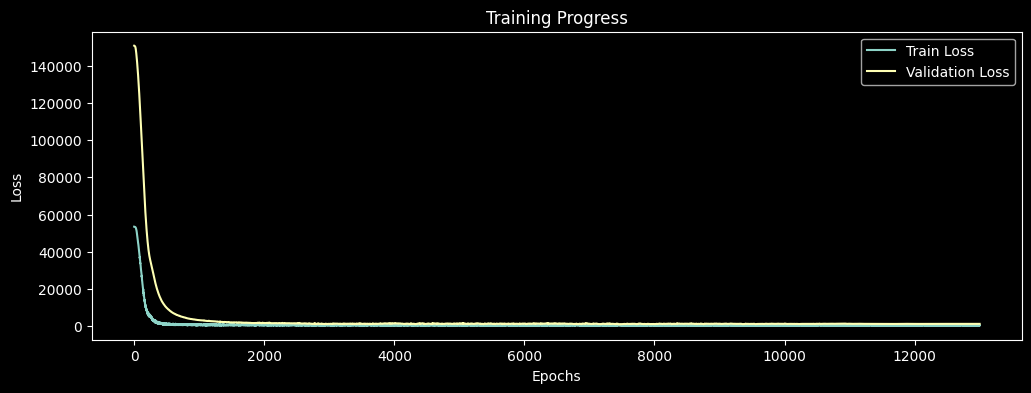

In [25]:
# plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

# Inference

In [26]:
# get predictions, without shuffling
y_train_hat = inference_regression(model, x_train_scaled, device)
y_val_hat = inference_regression(model, x_val_scaled, device)
y_test_hat = inference_regression(model, x_test_scaled, device)

In [27]:
y_train.shape, y_train_hat.shape

(torch.Size([89, 1]), torch.Size([89, 1]))

# Evaluate Model

In [28]:
mse_train = mean_squared_error(y_train, y_train_hat)
mse_val = mean_squared_error(y_val, y_val_hat)
mse_test = mean_squared_error(y_test, y_test_hat)

print(f"Train MSE: {mse_train:.2f}")
print(f"Val MSE: {mse_val:.2f}")
print(f"Test MSE: {mse_test:.2f}")

Train MSE: 6.82
Val MSE: 1234.78
Test MSE: 8717.90


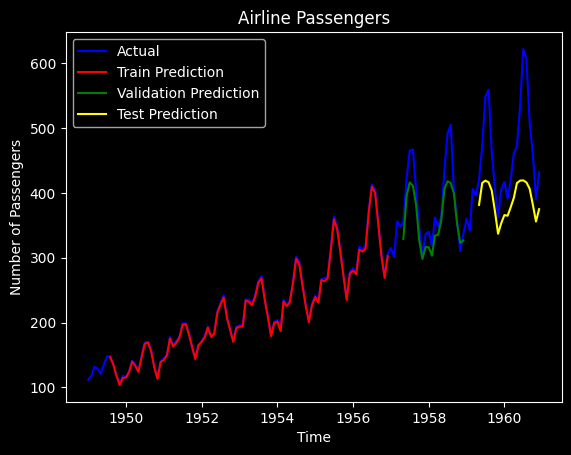

In [34]:
# Plot actual passenger data
plt.plot(timeseries['passengers'], color='blue', label='Actual')

# Calculate indices for plotting
train_start_idx = lookback + window_size - 1
train_end_idx = train_start_idx + len(y_train) - 1
val_start_idx = train_end_idx + window_size + 1
val_end_idx = val_start_idx + len(y_val) - 1
test_start_idx = len(timeseries) - len(y_test_hat)

# Plot predicted train data
plt.plot(timeseries.index[train_start_idx:train_end_idx + 1], y_train_hat, color='red', label='Train Prediction')

# Plot predicted validation data
plt.plot(timeseries.index[val_start_idx:val_end_idx + 1], y_val_hat, color='green', label='Validation Prediction')

# Plot predicted test data
plt.plot(timeseries.index[test_start_idx:], y_test_hat, color='yellow', label='Test Prediction')

# Add titles and labels
plt.title('Airline Passengers')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')

# Show legend
plt.legend()

# Display the plot
plt.show()